# Home Credit - Preprocessing
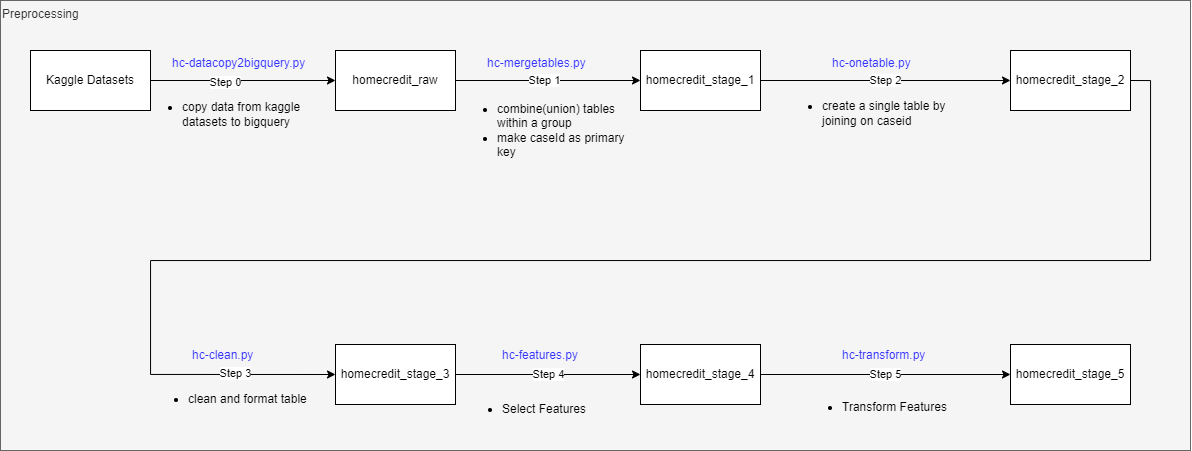

# Merge tables using joins
This program is part of step-2 as described in the above diagram.
It joins multiple table into a single table with case_id as the primary key

In [ ]:
pip install --upgrade google-cloud-bigquery

In [ ]:
import numpy as np
import pandas as pd
import csv
import os
from collections import defaultdict
from google.cloud import bigquery

In [ ]:
gc_project_id      = 'kagglehomecredit'
bq_dataset_source  = 'homecredit_stage_1'
bq_dataset_sink    = 'homecredit_stage_2' 
create_table_name  = 'train_homecredit'

In [ ]:
asis_table_list=[
    'train_base'
    ,'train_static_0'
    ,'train_static_cb_0'
    ,'train_debitcard_1'
    ,'train_deposit_1'
    ,'train_other_1'
    ,'train_tax_registry_a_1'
    ,'train_tax_registry_b_1'
    ,'train_tax_registry_c_1'
]

In [ ]:
def create_bq_client(gc_project_id):
    bq_client = bigquery.Client(project=gc_project_id)
    return bq_client
    
    
def create_bq_dataset(bq_client, bq_dataset):
    bq_client.create_dataset(bq_dataset, exists_ok=True)
    return


def get_table_column(gc_project_id, bq_dataset):
    table_column = defaultdict(list)
    
    sql_query = f"""SELECT * FROM `{gc_project_id}.{bq_dataset_source}.INFORMATION_SCHEMA.COLUMNS`; """
    results   = bq_client.query_and_wait(sql_query)
    
    for result in results:
        table_column[result["table_name"]].append(result["column_name"])
    return table_column


def get_caseid_bucket_minmax():
    caseid_bucket_minmax = defaultdict(list)
    sql_query=f"""
                with histogram_data as
                (
                  select case_id,
                  ntile(10000) over (order by case_id) as bucket,
                  count(*) as counts
                  from `kagglehomecredit.homecredit_stage_1.train_base`
                  group by case_id
                )
                select 
                bucket,
                min(case_id) as min_case_id,
                max(case_id) as max_case_id,
                count(*) as counts
                from histogram_data
                group by bucket
                order by bucket
                """
    results   = bq_client.query_and_wait(sql_query)
    for result in results:
        caseid_bucket_minmax[result["bucket"]].append(result["min_case_id"])
        caseid_bucket_minmax[result["bucket"]].append(result["max_case_id"])
    
    return caseid_bucket_minmax

def flatten_train_applprev(selected_table):
       
    sql_query = f"""create or replace table `{gc_project_id}.{bq_dataset_sink}.train_applprev_1` as
                    select 
                       t_ap1.case_id    as case_id
                      ,t_ap1.num_group1 as num_group1
                      ,{selected_table['train_applprev_1']}
                      ,ARRAY_AGG(STRUCT(t_ap2.num_group2 as num_group2, {selected_table['train_applprev_2']})) as ap2
                    from       kagglehomecredit.homecredit_stage_1.train_applprev_1   t_ap1 
                    left join  kagglehomecredit.homecredit_stage_1.train_applprev_2   t_ap2
                    on   t_ap1.case_id    = t_ap2.case_id
                    and  t_ap1.num_group1 = t_ap2.num_group1
                    group by
                      t_ap1.case_id
                     ,t_ap1.num_group1
                     ,{selected_table['train_applprev_1']}
                """
    
    print(sql_query)
    print("Query execution Started: ")
    bq_client.query_and_wait(sql_query)
    print("Query execution Completed")  
    
    return

def flatten_train_person(selected_table):
       
    sql_query = f"""create or replace table `{gc_project_id}.{bq_dataset_sink}.train_person_1` as
                    select 
                       t_pr1.case_id    as case_id
                      ,t_pr1.num_group1 as num_group1
                      ,{selected_table['train_person_1']}
                      ,ARRAY_AGG(STRUCT(t_pr2.num_group2 as num_group2, {selected_table['train_person_2']})) as pr2
                    from       kagglehomecredit.homecredit_stage_1.train_person_1   t_pr1 
                    left join  kagglehomecredit.homecredit_stage_1.train_person_2   t_pr2
                    on   t_pr1.case_id    = t_pr2.case_id
                    and  t_pr1.num_group1 = t_pr2.num_group1
                    group by
                      t_pr1.case_id
                     ,t_pr1.num_group1
                     ,{selected_table['train_person_1']}
                """
    
    print(sql_query)
    print("Query execution Started: ")
    bq_client.query_and_wait(sql_query)
    print("Query execution Completed")  
    
    return

def flatten_train_credit_bureau_a(selected_table):
       
    sql_query = f"""create or replace table `{gc_project_id}.{bq_dataset_sink}.train_credit_bureau_a_1` as
                    select 
                       t_cba1.case_id    as case_id
                      ,t_cba1.num_group1 as num_group1
                      ,{selected_table['train_credit_bureau_a_1']}
                      ,ARRAY_AGG(STRUCT(t_cba2.num_group2 as num_group2, {selected_table['train_credit_bureau_a_2']})) as cba2
                    from       kagglehomecredit.homecredit_stage_1.train_credit_bureau_a_1   t_cba1 
                    left join  kagglehomecredit.homecredit_stage_1.train_credit_bureau_a_2   t_cba2
                    on   t_cba1.case_id    = t_cba2.case_id
                    and  t_cba1.num_group1 = t_cba2.num_group1
                    group by
                      t_cba1.case_id
                     ,t_cba1.num_group1
                     ,{selected_table['train_credit_bureau_a_1']}
                """
    
    print(sql_query)
    print("Query execution Started: ")
    bq_client.query_and_wait(sql_query)
    print("Query execution Completed")  
    
    return
    
def flatten_train_credit_bureau_b(selected_table):
       
    sql_query = f"""create or replace table `{gc_project_id}.{bq_dataset_sink}.train_credit_bureau_b_1` as
                    select 
                       t_cbb1.case_id    as case_id
                      ,t_cbb1.num_group1 as num_group1
                      ,{selected_table['train_credit_bureau_b_1']}
                      ,ARRAY_AGG(STRUCT(t_cbb2.num_group2 as num_group2, {selected_table['train_credit_bureau_b_2']})) as cbb2
                    from       kagglehomecredit.homecredit_stage_1.train_credit_bureau_b_1   t_cbb1 
                    left join  kagglehomecredit.homecredit_stage_1.train_credit_bureau_b_2   t_cbb2
                    on   t_cbb1.case_id    = t_cbb2.case_id
                    and  t_cbb1.num_group1 = t_cbb2.num_group1
                    group by
                      t_cbb1.case_id
                     ,t_cbb1.num_group1
                     ,{selected_table['train_credit_bureau_b_1']}
                """
    
    print(sql_query)
    print("Query execution Started: ")
    bq_client.query_and_wait(sql_query)
    print("Query execution Completed")  
    
    return


def copy_asis(table_name):
    sql_query = f""" create or replace table `{gc_project_id}.{bq_dataset_sink}.{table_name}` as
                select * from `{gc_project_id}.{bq_dataset_source}.{table_name}`
                """
    print(sql_query)
    print("Query execution Started: ")
    bq_client.query_and_wait(sql_query)
    print("Query execution Completed")  
    
    return

In [ ]:
bq_client = create_bq_client(gc_project_id)
create_bq_dataset(bq_client, bq_dataset_sink)

In [ ]:
table_column = get_table_column(gc_project_id,bq_dataset_source)

In [ ]:
selected_table   = defaultdict(list)
selected_columns = []

for table_name, table_columns in table_column.items():
    
    selected_columns = [s for s in table_columns if s not in ['case_id', 'num_group1', 'num_group2']]
    delimiter = ", "
    selected_columns_string = delimiter.join(selected_columns)
    selected_table[table_name] = selected_columns_string 

In [ ]:
flatten_train_applprev(selected_table)
flatten_train_person(selected_table)
flatten_train_credit_bureau_a(selected_table)
flatten_train_credit_bureau_b(selected_table)

for table_name in asis_table_list:
    copy_asis(table_name)